<a href="https://colab.research.google.com/github/Darshansingh11/SMAI-FP/blob/main/Deconvolution_vgg.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

%cd "/content/drive/My Drive/SMAI/Understanding_CNN"

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/My Drive/SMAI/Understanding_CNN


In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.models as models
from functools import partial
import numpy as np
import matplotlib.pyplot as plt
from collections import OrderedDict
import json
import random
import os

In [3]:
from torchvision.transforms import transforms
import cv2

In [4]:
def seed_everything(seed: int):  
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = True

seed_everything(23)

In [5]:
class Vgg16Conv(nn.Module):

    def __init__(self, num_cls=1000):

        super(Vgg16Conv, self).__init__()
    
        self.features = nn.Sequential(

            # CONVOLUTION MODULE 1
            nn.Conv2d(3, 64, 3, padding=1), #0
            nn.ReLU(), #1
            nn.Conv2d(64, 64, 3, padding=1), #2
            nn.ReLU(), #3
            nn.MaxPool2d(2, stride=2, return_indices=True), #4
            
            # CONVOLUTION MODULE 2
            nn.Conv2d(64, 128, 3, padding=1), #5
            nn.ReLU(),#6
            nn.Conv2d(128, 128, 3, padding=1),#7
            nn.ReLU(),#8
            nn.MaxPool2d(2, stride=2, return_indices=True),#9

            # CONVOLUTION MODULE 3
            nn.Conv2d(128, 256, 3, padding=1),#10
            nn.ReLU(),#11
            nn.Conv2d(256, 256, 3, padding=1),#12
            nn.ReLU(),#13
            nn.Conv2d(256, 256, 3, padding=1),#14
            nn.ReLU(),#15
            nn.MaxPool2d(2, stride=2, return_indices=True),#16

            # CONVOLUTION MODULE 4
            nn.Conv2d(256, 512, 3, padding=1),#17
            nn.ReLU(),#18
            nn.Conv2d(512, 512, 3, padding=1),#19
            nn.ReLU(),#20
            nn.Conv2d(512, 512, 3, padding=1),#21
            nn.ReLU(),#22
            nn.MaxPool2d(2, stride=2, return_indices=True),#23

            # CONVOLUTION MODULE 5
            nn.Conv2d(512, 512, 3, padding=1),#24
            nn.ReLU(),#25
            nn.Conv2d(512, 512, 3, padding=1),#26
            nn.ReLU(),#27
            nn.Conv2d(512, 512, 3, padding=1),#28
            nn.ReLU(),#29
            nn.MaxPool2d(2, stride=2, return_indices=True)#30
        )

        #CLASSIFICATION PART
        self.classifier = nn.Sequential(
            nn.Linear(512 * 7 * 7, 4096),
            nn.ReLU(),
            nn.Dropout(),
            nn.Linear(4096, 4096),
            nn.ReLU(),
            nn.Dropout(),
            nn.Linear(4096, num_cls),
            nn.Softmax(dim=1)
        )

        # INDEX OF CONVOLUTIONAL LAYERS
        self.conv_layer_indices = [0, 2, 5, 7, 10, 12, 14, 17, 19, 21, 24, 26, 28]

        # feature maps
        self.feature_maps = OrderedDict()
        # switch
        self.switches = OrderedDict()
        # initial weight
        self.init_weights()

    def init_weights(self):

        #LOADING THE PRETRAINED VGG-16 MODEL
        vgg16_pretrained = models.vgg16(pretrained=True)
        
        #FEATURE MODULE
        #ITERATING THE FEATURES 
        for idx, layer in enumerate(vgg16_pretrained.features):

            #CHECKING IF THE LAYER IS A CONV2D LAYER
            if isinstance(layer, nn.Conv2d):

                #COPYING THE CONV2D WEIGHTS FROM THE MODEL TO THE DEFINED MODEL
                self.features[idx].weight.data = layer.weight.data

                #COPYING THE CONV2D BIAS FROM THE MODEL TO THE DEFINED MODEL
                self.features[idx].bias.data = layer.bias.data

        #CLASSIFIER MODULE
        #ITERATING THE FEATURES 
        for idx, layer in enumerate(vgg16_pretrained.classifier):
            
            #CHECKING IF THE LAYER IS A LINEAR LAYER
            if isinstance(layer, nn.Linear):

                #COPYING THE LINEAR WEIGHTS FROM THE MODEL TO THE DEFINED MODEL
                self.classifier[idx].weight.data = layer.weight.data

                #COPYING THE LINEAR BIAS FROM THE MODEL TO THE DEFINED MODEL
                self.classifier[idx].bias.data = layer.bias.data
    
    #VERIFIYING IF THE WEIGHTS AND BIASES ARE CORRECTLY COPIED
    def check(self):
        model = models.vgg16(pretrained=True)
        return model

    #x : DATA
    def forward(self, x):
        
        #ITERATING OVER THE LAYERS
        for idx, layer in enumerate(self.features):
            
            #IF THE LAYER IS A MAXPOOLING LAYER
            if isinstance(layer, nn.MaxPool2d):
                #GETTING THE LOCATION
                x, location = layer(x)
            else:
                x = layer(x)
        
        #FOR THE CLASSIFIER PARR
        # reshape to (1, 512 * 7 * 7)
        x = x.view(x.size()[0], -1)
        output = self.classifier(x)
        return output

In [6]:
class Vgg16Deconv(nn.Module):

    def __init__(self):
        super(Vgg16Deconv, self).__init__()

        self.features = nn.Sequential(
            # deconv1
            nn.MaxUnpool2d(2, stride=2), #0
            nn.ReLU(),#1
            nn.ConvTranspose2d(512, 512, 3, padding=1),#2
            nn.ReLU(),#3
            nn.ConvTranspose2d(512, 512, 3, padding=1),#4
            nn.ReLU(),#5
            nn.ConvTranspose2d(512, 512, 3, padding=1),#6

            # deconv2
            nn.MaxUnpool2d(2, stride=2),#7
            nn.ReLU(),#8
            nn.ConvTranspose2d(512, 512, 3, padding=1),#9
            nn.ReLU(),#10
            nn.ConvTranspose2d(512, 512, 3, padding=1),#11
            nn.ReLU(),#12
            nn.ConvTranspose2d(512, 256, 3, padding=1),#13
            
            # deconv3
            nn.MaxUnpool2d(2, stride=2),#14
            nn.ReLU(),#15
            nn.ConvTranspose2d(256, 256, 3, padding=1),#16
            nn.ReLU(),#17
            nn.ConvTranspose2d(256, 256, 3, padding=1),#18
            nn.ReLU(),#19
            nn.ConvTranspose2d(256, 128, 3, padding=1),#20
            
            # deconv4
            nn.MaxUnpool2d(2, stride=2),#21
            nn.ReLU(),#22
            nn.ConvTranspose2d(128, 128, 3, padding=1),#23
            nn.ReLU(),#24
            nn.ConvTranspose2d(128, 64, 3, padding=1),#25
            
            # deconv5
            nn.MaxUnpool2d(2, stride=2),#26
            nn.ReLU(), #27
            nn.ConvTranspose2d(64, 64, 3, padding=1), #28
            nn.ReLU(), #29
            nn.ConvTranspose2d(64, 3, 3, padding=1) #30    
        )

        #MAPPING OF CONVOLUTION LAYERS FROM VGG-16-TRANSPOSE TO VGG-16
        self.conv2deconv_indices = {
                0:30, 2:28, 5:25, 7:23,
                10:20, 12:18, 14:16, 17:13,
                19:11, 21:9, 24:6, 26:4, 28:2
                }

        #MAPPING OF MAXPOOLING LAYERS FROM VGG-16-TRANSPOSE TO VGG-16
        self.unpool2pool_indices = {
                26:4, 21:9, 14:16, 7:23, 0:30
                }

        self.layer_mapping = {5:0, 4:7, 3:14, 2:21, 1:26}

        self.init_weight()

    def init_weight(self):

        #LOADING THE PRETRAINED MODEL
        vgg16_pretrained = models.vgg16(pretrained=True)

        #TRAVERSING THE VGG-16 FEATURES
        for idx, layer in enumerate(vgg16_pretrained.features):
            
            #CHECKING IF THE LAYER IS A CONV2D LAYER
            if isinstance(layer, nn.Conv2d):

                #COPYING THE CONV2D WEIGHTS FROM THE MODEL TO THE INVERTED MODEL
                self.features[self.conv2deconv_indices[idx]].weight.data = layer.weight.data
                
                #COPYING THE CONV2D BIAS FROM THE MODEL TO THE INVERTED MODEL
                #self.features[self.conv2deconv_indices[idx]].bias.data = layer.bias.data
        
    #INPUT : DATA, LAYER_NUMBER, 
    def forward(self, x, layer, activation_idx, switches):
        

        start_idx = self.layer_mapping[layer]

        for idx in range(start_idx, len(self.features)):
            
            #CHECKING IF IT IS A MAXPOOLING LAYER
            if isinstance(self.features[idx], nn.MaxUnpool2d):
                
                #PERFORMING THE UNPOOLING FROM PARTICULAR INDEX
                x = self.features[idx](x, switches[self.unpool2pool_indices[idx]])
            else:
                #ELSE GETTING ONLY THE OUTPUT
                x = self.features[idx](x)
        #RETURNING THE FEATURE VECTOR
        return x

In [7]:
def load_images(img_path):

    img = cv2.imread(img_path)
    img = cv2.resize(img, (224, 224))
    plt.imshow(img)

    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406],std=[0.229, 0.224, 0.225])
        ])
    
    img = transform(img)
    img.unsqueeze_(0)
    return img

In [8]:
def store(model):
    def hook(module, input, output, key):
        if isinstance(module, nn.MaxPool2d):
           model.feature_maps[key] = output[0]
           model.switches[key] = output[1]
        else:
           model.feature_maps[key] = output
    
    for idx, layer in enumerate(model._modules.get('features')):    
        # _modules returns an OrderedDict
        layer.register_forward_hook(partial(hook, key=idx))

In [9]:
def visualize_layer(layer_num, conv, deconv):
    layer_mapping = {1:4, 2:9, 3:16, 4:23, 5:30}
    layer = layer_mapping[layer_num]

    num_feat = conv.feature_maps[layer].shape[1]
    
    # set other feature map activations to zero
    new_feat_map = conv.feature_maps[layer].clone()

    # choose the max activations map
    act_lst = []
    for i in range(0, num_feat):
        choose_map = new_feat_map[0, i, :, :]
        activation = torch.max(choose_map)
        act_lst.append(activation.item())

    act_lst = np.array(act_lst)
    mark = np.argmax(act_lst)

    choose_map = new_feat_map[0, mark, :, :]
    max_activation = torch.max(choose_map)
    
    # make zeros for other feature maps
    if mark == 0:
        new_feat_map[:, 1:, :, :] = 0
    else:
        new_feat_map[:, :mark, :, :] = 0
        if mark != conv.feature_maps[layer].shape[1] - 1:
            new_feat_map[:, mark + 1:, :, :] = 0
    
    choose_map = torch.where(choose_map==max_activation,
            choose_map,
            torch.zeros(choose_map.shape)
            )

    # make zeros for ther activations
    new_feat_map[0, mark, :, :] = choose_map
    
    # print(torch.max(new_feat_map[0, mark, :, :]))    
    # print(max_activation)
    # print("input activation", new_feat_map.shape)
    deconv_output = deconv(new_feat_map, layer_num, mark, conv.switches)

    new_img = deconv_output.data.numpy()[0].transpose(1, 2, 0)  # (H, W, C)
    # normalize
    new_img = (new_img - new_img.min()) / (new_img.max() - new_img.min()) * 255
    new_img = new_img.astype(np.uint8)
    # cv2.imshow('reconstruction img ' + str(layer), new_img)
    # cv2.waitKey()
    return new_img, int(max_activation)

In [50]:
def normalise_img(img):

    transform = transforms.Compose([transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],std=[0.229, 0.224, 0.225])])
    img = transform(img)
    return img

def predict(model, image, labels, occ=False, cls=None):
    scores = model(image).data[0]
    if not occ:
        cls_score, index = scores.max(0)
        return str(index.item()), labels[str(index.item())][1], round(cls_score.item(), 2)
    # print(scores[0])
    if occ:
        cls_score, index = scores[cls], cls
    # print(index)
    # print(type(index))
    # print(index.shape)
        return str(index), labels[str(index)][1], round(cls_score.item(), 2)

def process_images(img):
    img = cv2.resize(img, (224, 224))
    img = normalise_img(img)
    img = torch.unsqueeze(img,0)
    return img

model = models.vgg16(pretrained=True)
labels = json.load(open('labels/imagenet_class_index.json'))

def visualise_for_image(img, occ=False, cls=None):

    img_orig = img
    img = process_images(img)
    pred = predict(model, img, labels, occ, cls)
    vgg16_conv = Vgg16Conv()
    vgg16_conv.eval()
    store(vgg16_conv)
    conv_output = vgg16_conv(img)
    pool_locs = vgg16_conv.switches


    if not occ:
        print('Predicted:', pred)
    if occ:
        print("The score for the ground truth class", pred[1], "after occluding is =", pred[2])

    vgg16_deconv = Vgg16Deconv()
    vgg16_deconv.eval()
    plt.figure(figsize=(40,40), dpi=80)
    img = cv2.resize(img_orig, (224, 224))
    plt.subplot(4,4,1)
    plt.imshow(img[:,:,::-1])
    plt.title("Original")
    plt.axis("off")
    i=2
    for idx, layer in enumerate([1, 2, 3, 4, 5]):      
        img, activation = visualize_layer(layer, vgg16_conv, vgg16_deconv)
        plt.subplot(4,4,i)
        plt.title(f'Layer : {layer}')
        plt.imshow(img)
        plt.axis("off")
        i+=1
    plt.show()

Predicted: ('281', 'tabby', 16.06)


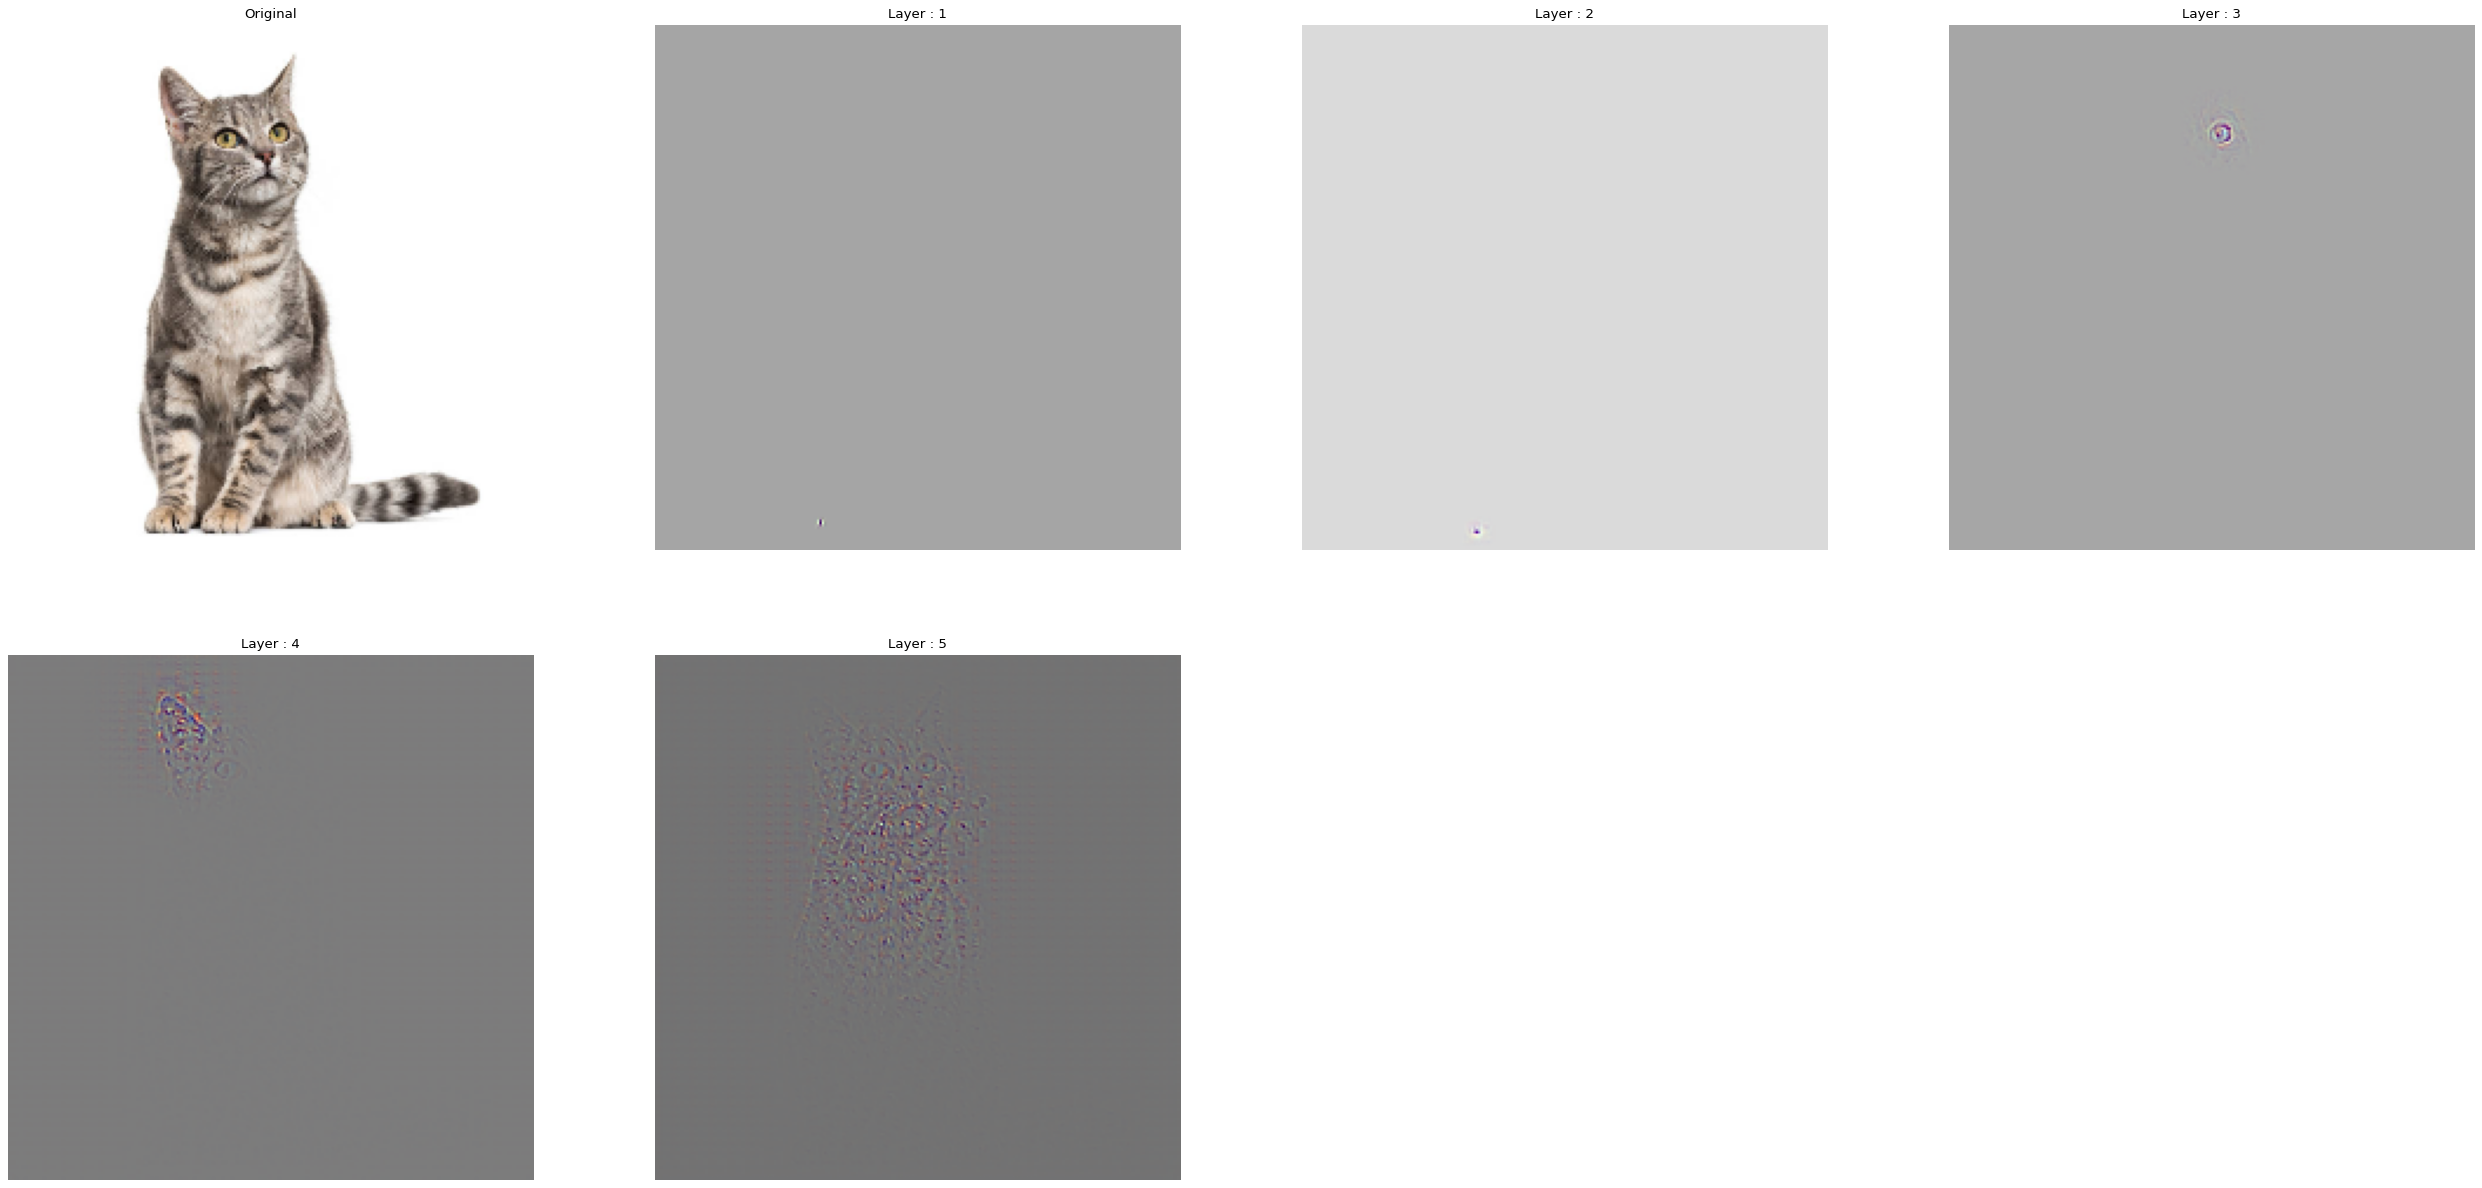

In [74]:
img_orig = cv2.imread('imgs/cat.jpg')
visualise_for_image(img_orig)

Predicted: ('340', 'zebra', 22.57)


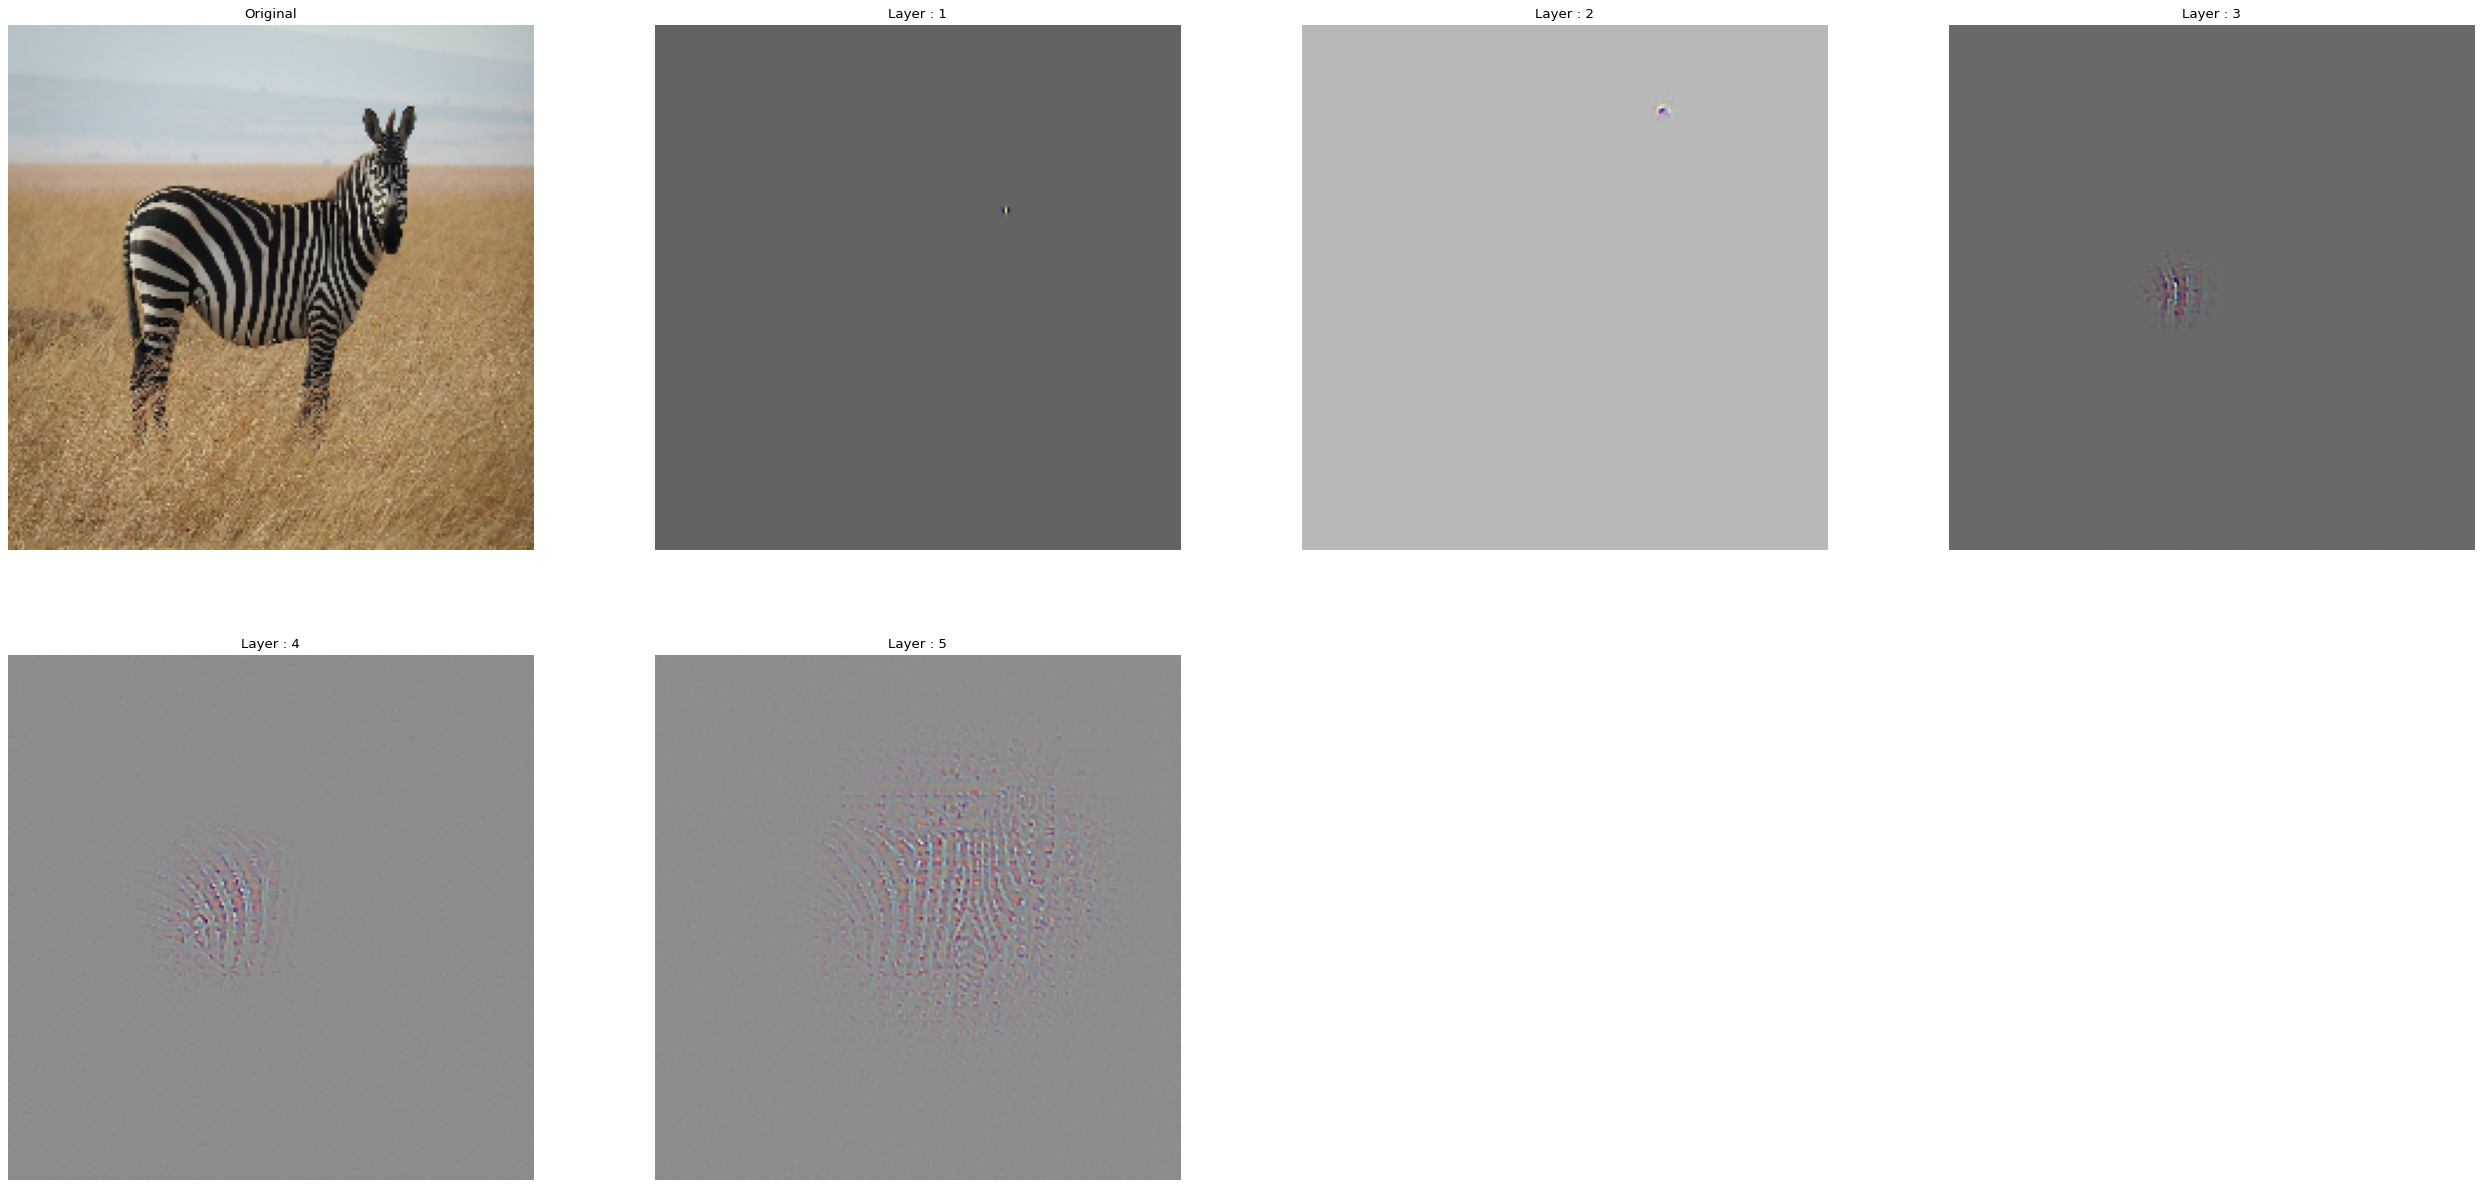

In [60]:
img_orig = cv2.imread('imgs/zebra.jpeg')
visualise_for_image(img_orig)

Predicted: ('94', 'hummingbird', 21.15)


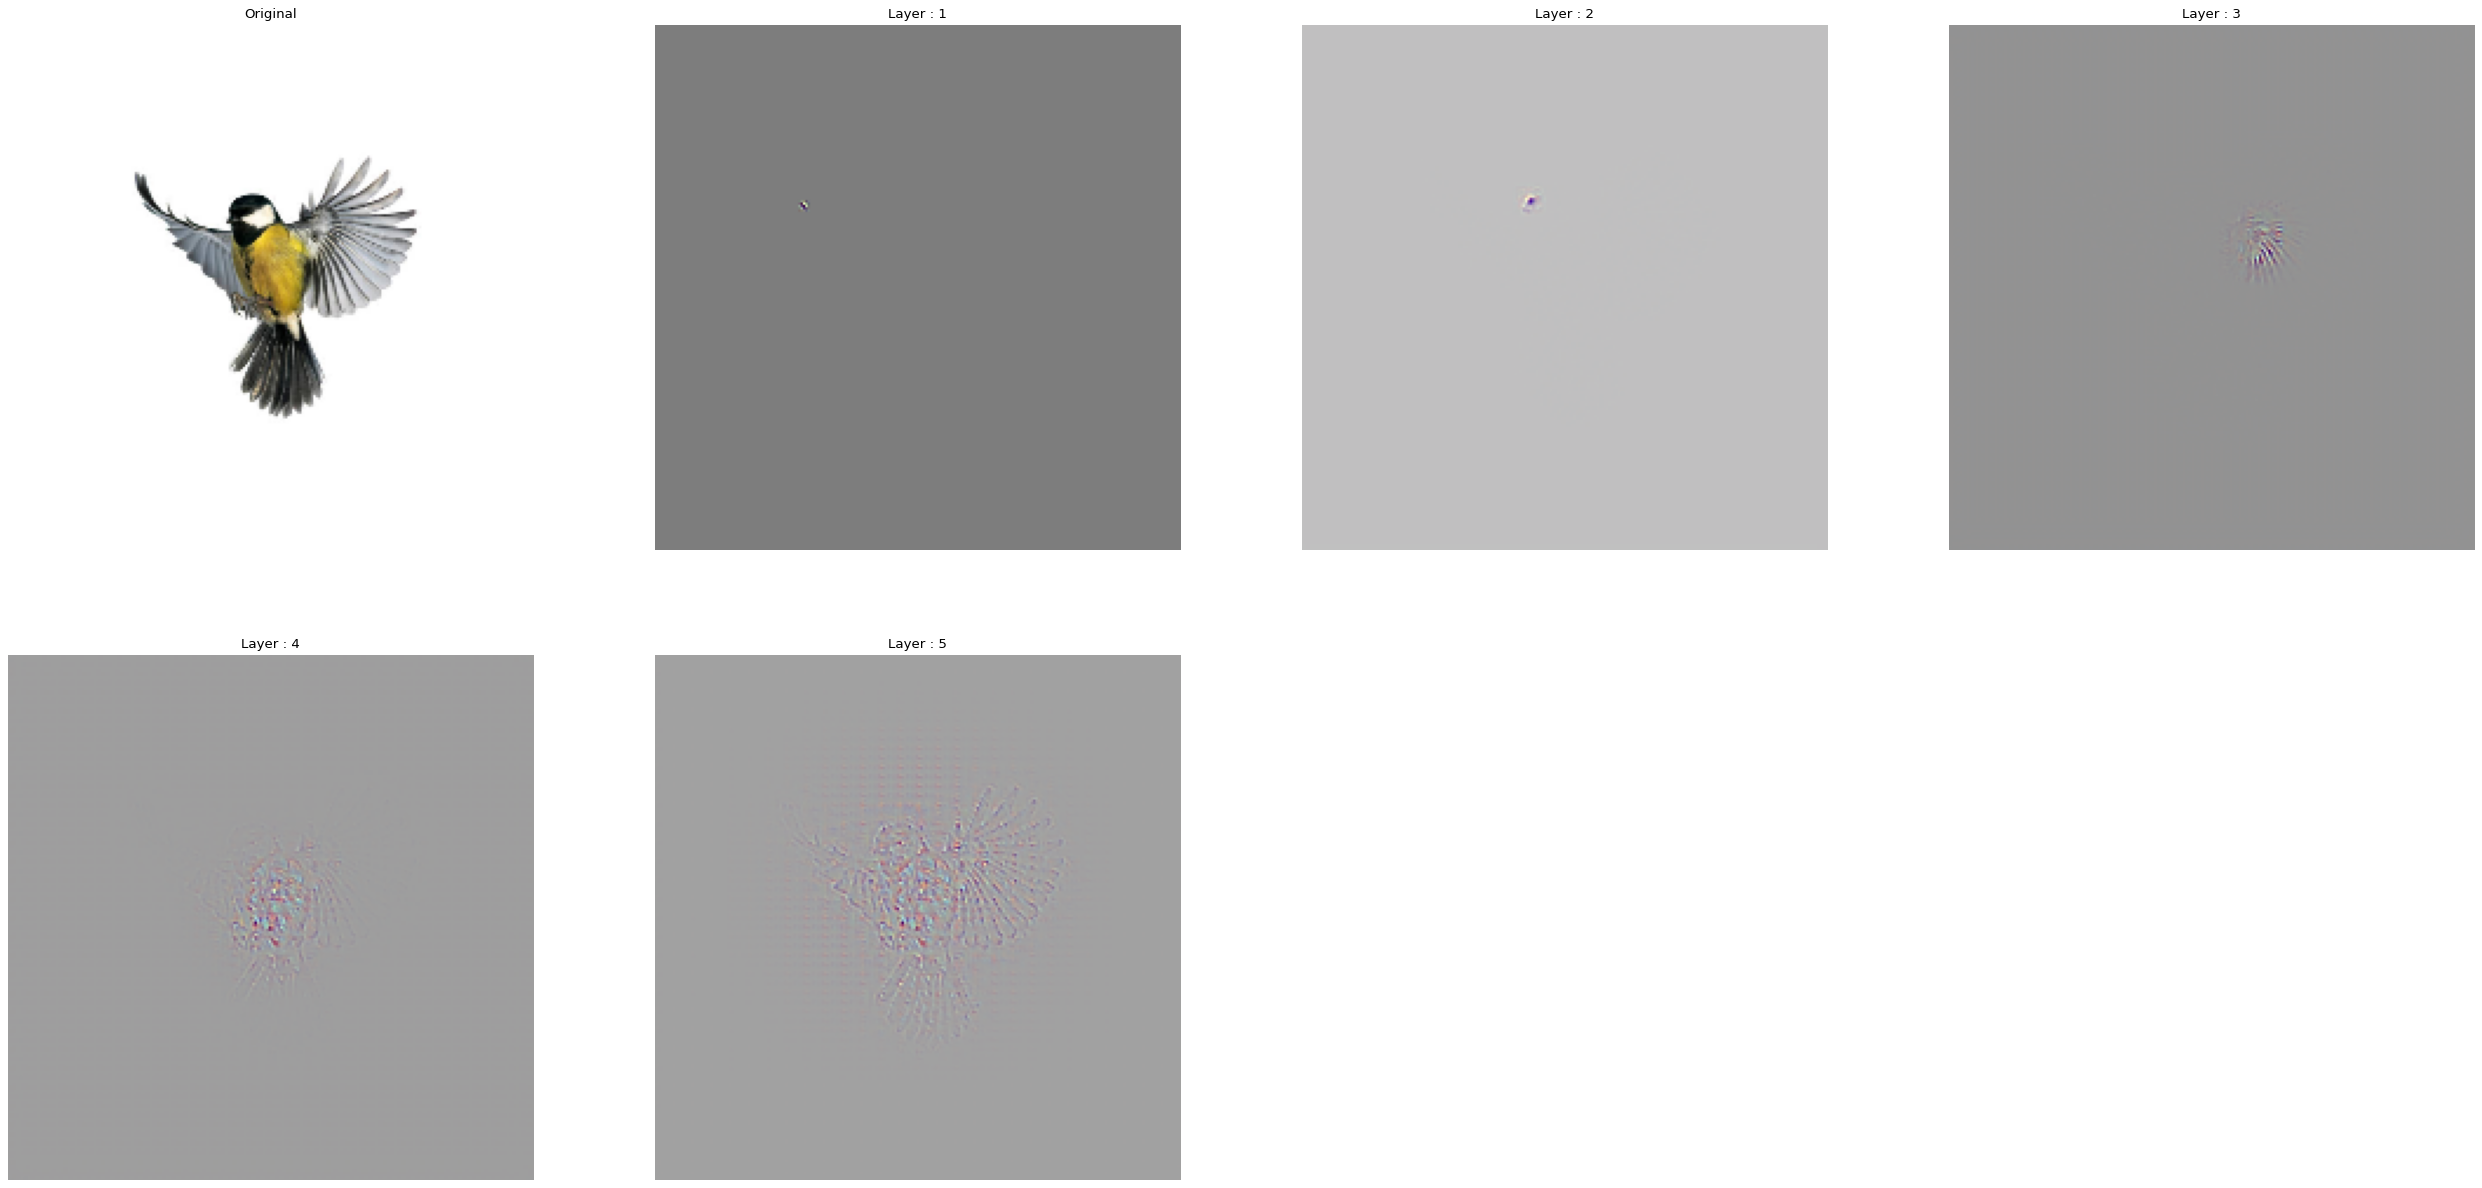

In [61]:
img_orig = cv2.imread('imgs/bird.jpg')
visualise_for_image(img_orig)

Predicted: ('222', 'kuvasz', 17.25)


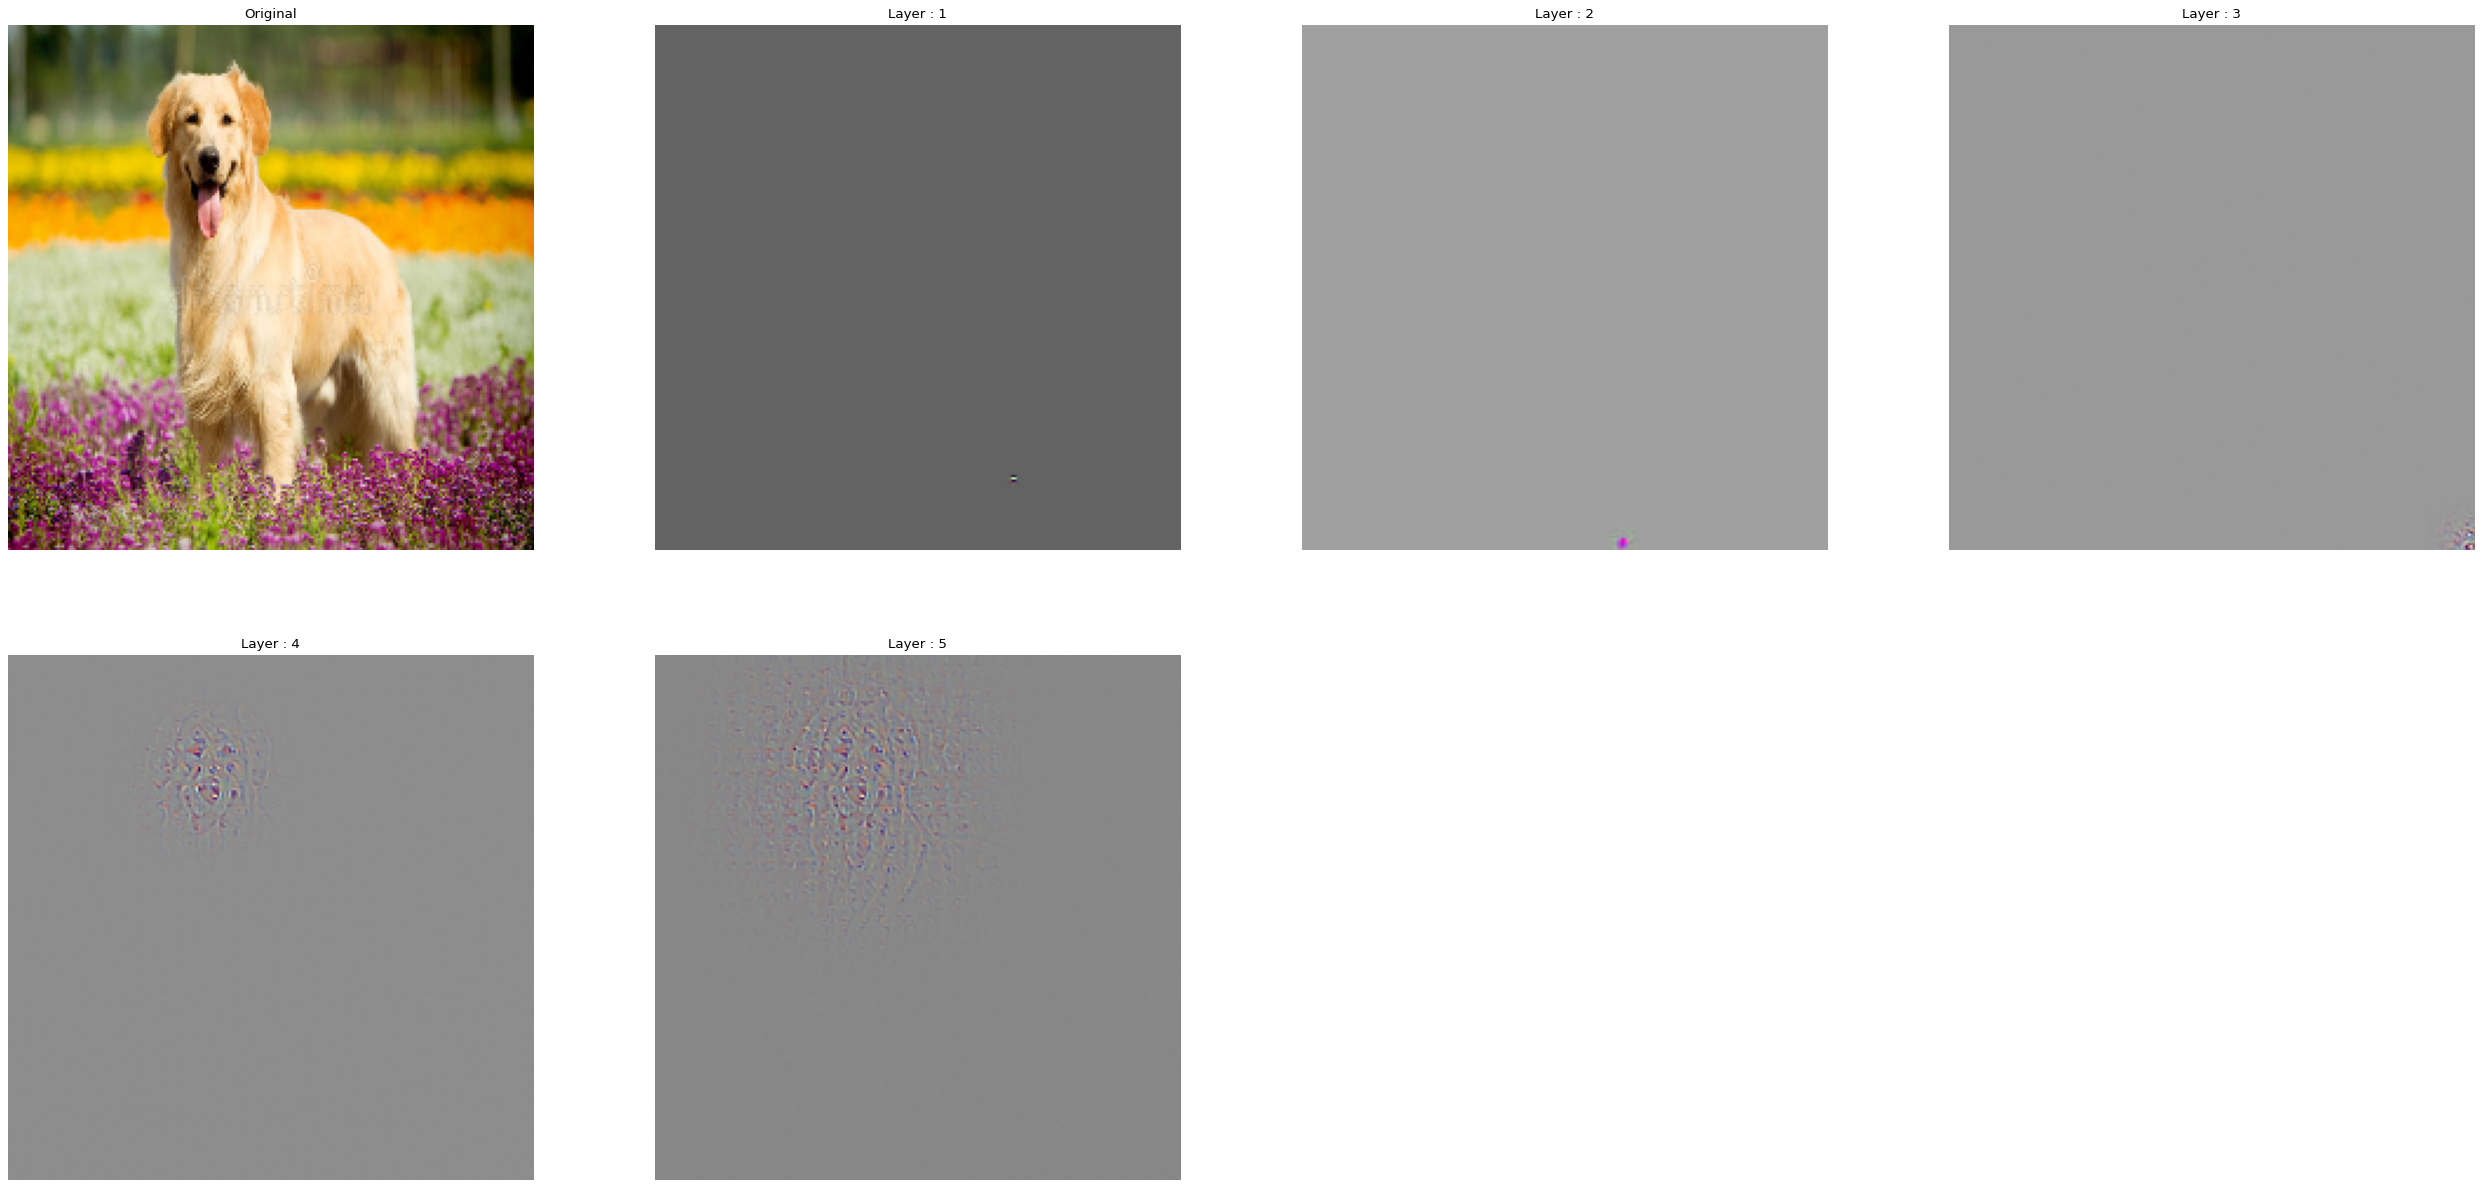

In [62]:
img_orig = cv2.imread('imgs/dog.jpg')
visualise_for_image(img_orig)

Predicted: ('985', 'daisy', 16.71)


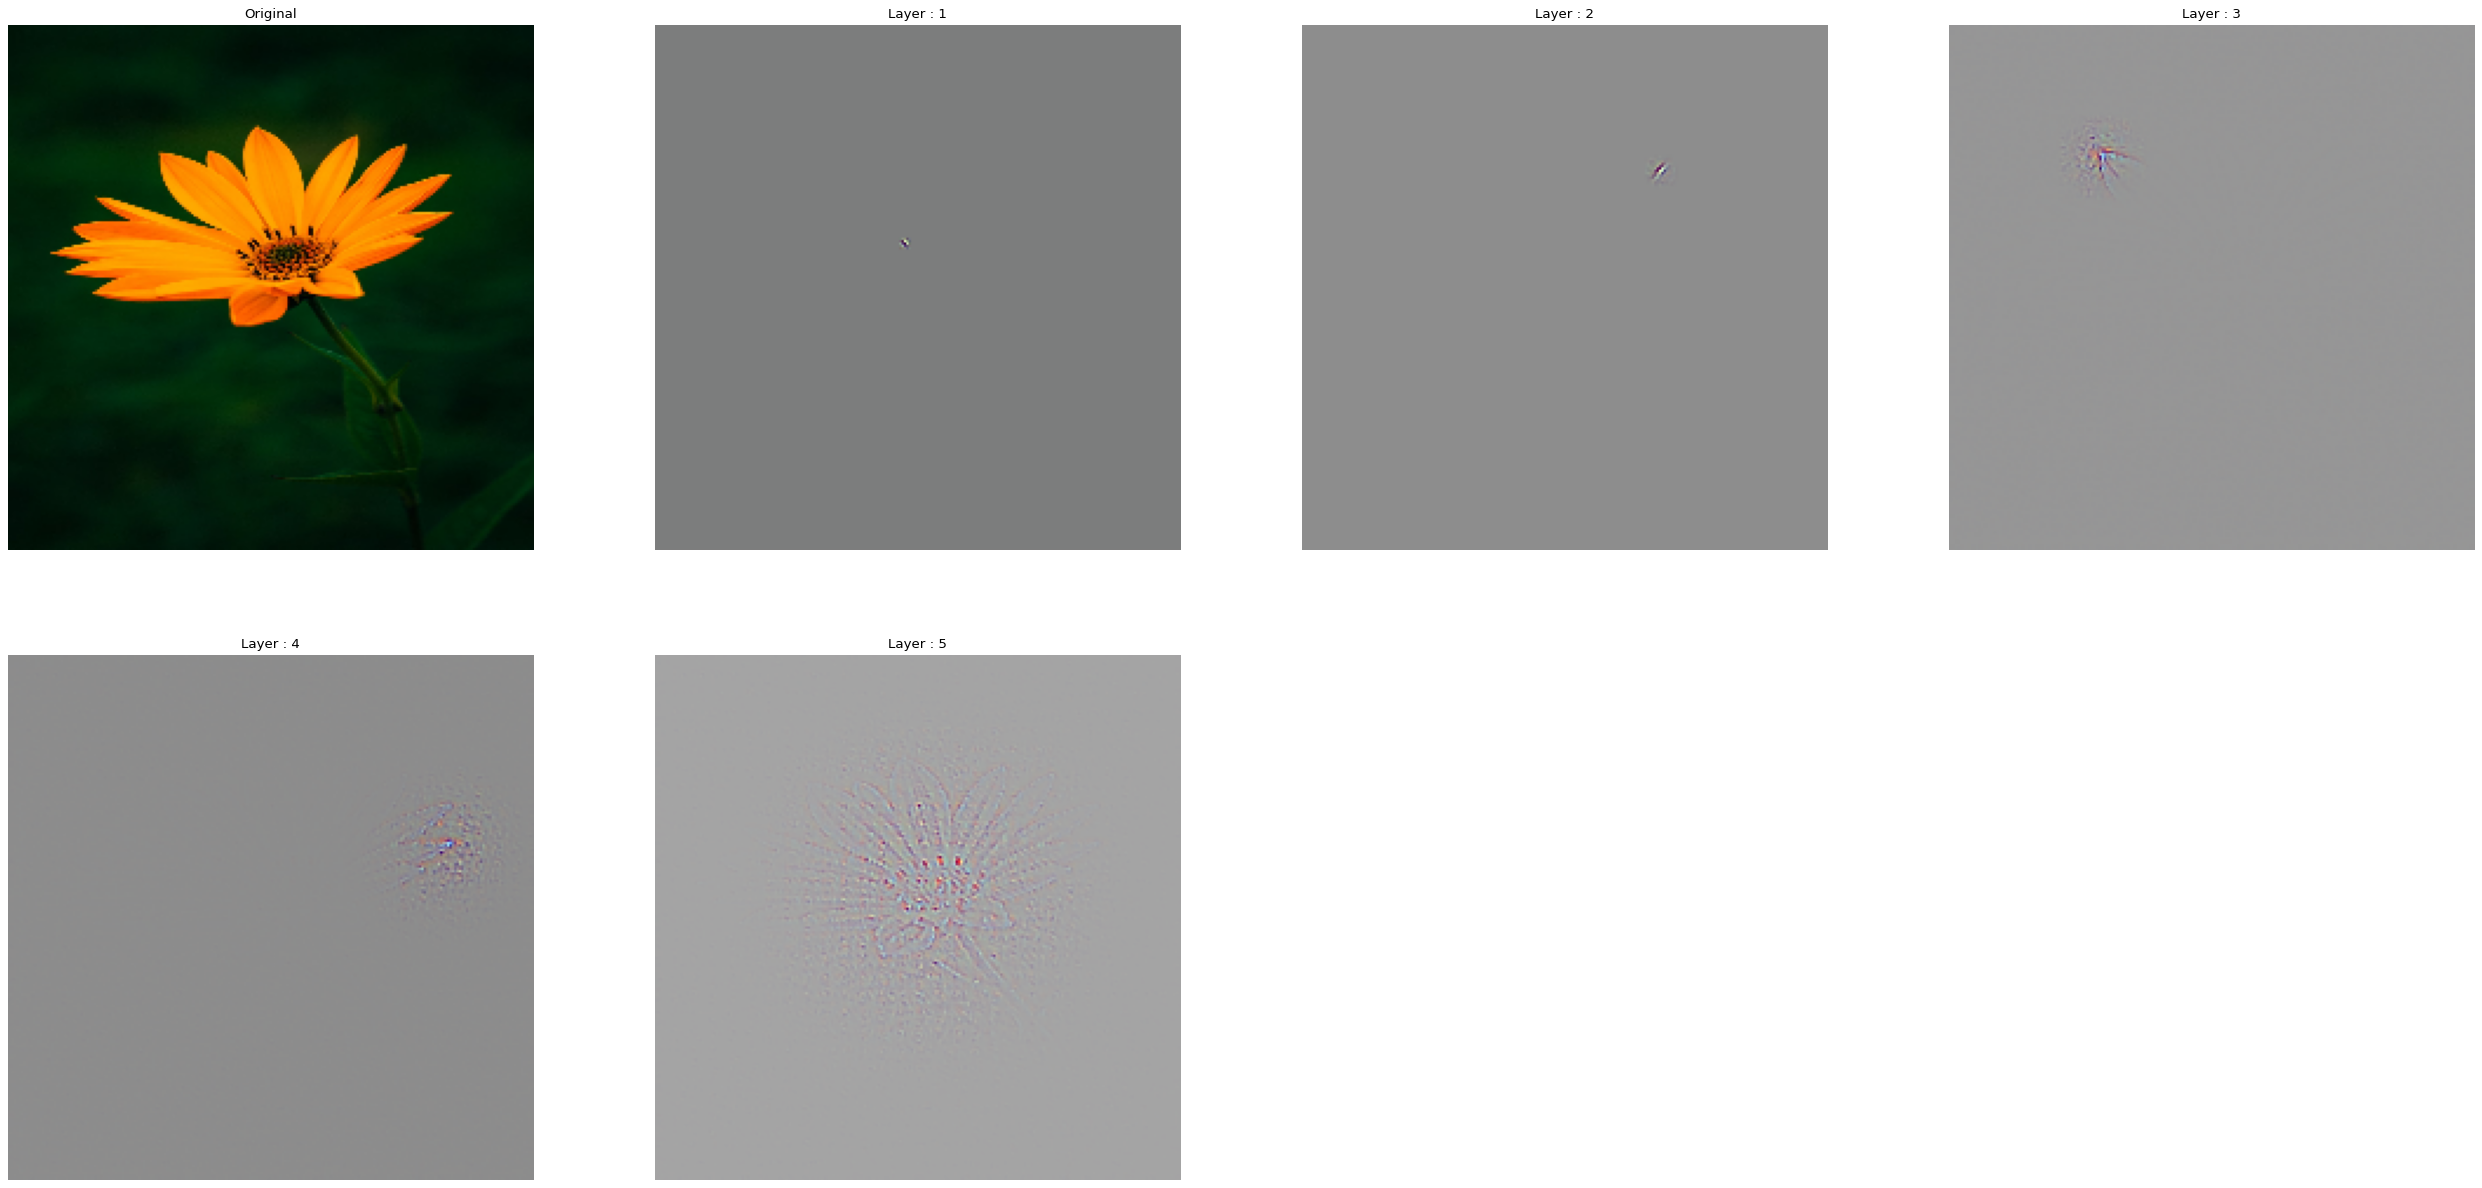

In [71]:
img_orig = cv2.imread('imgs/flower.jpeg')
visualise_for_image(img_orig)

### Occlusion

The score for the ground truth class tabby after occluding is = 15.26


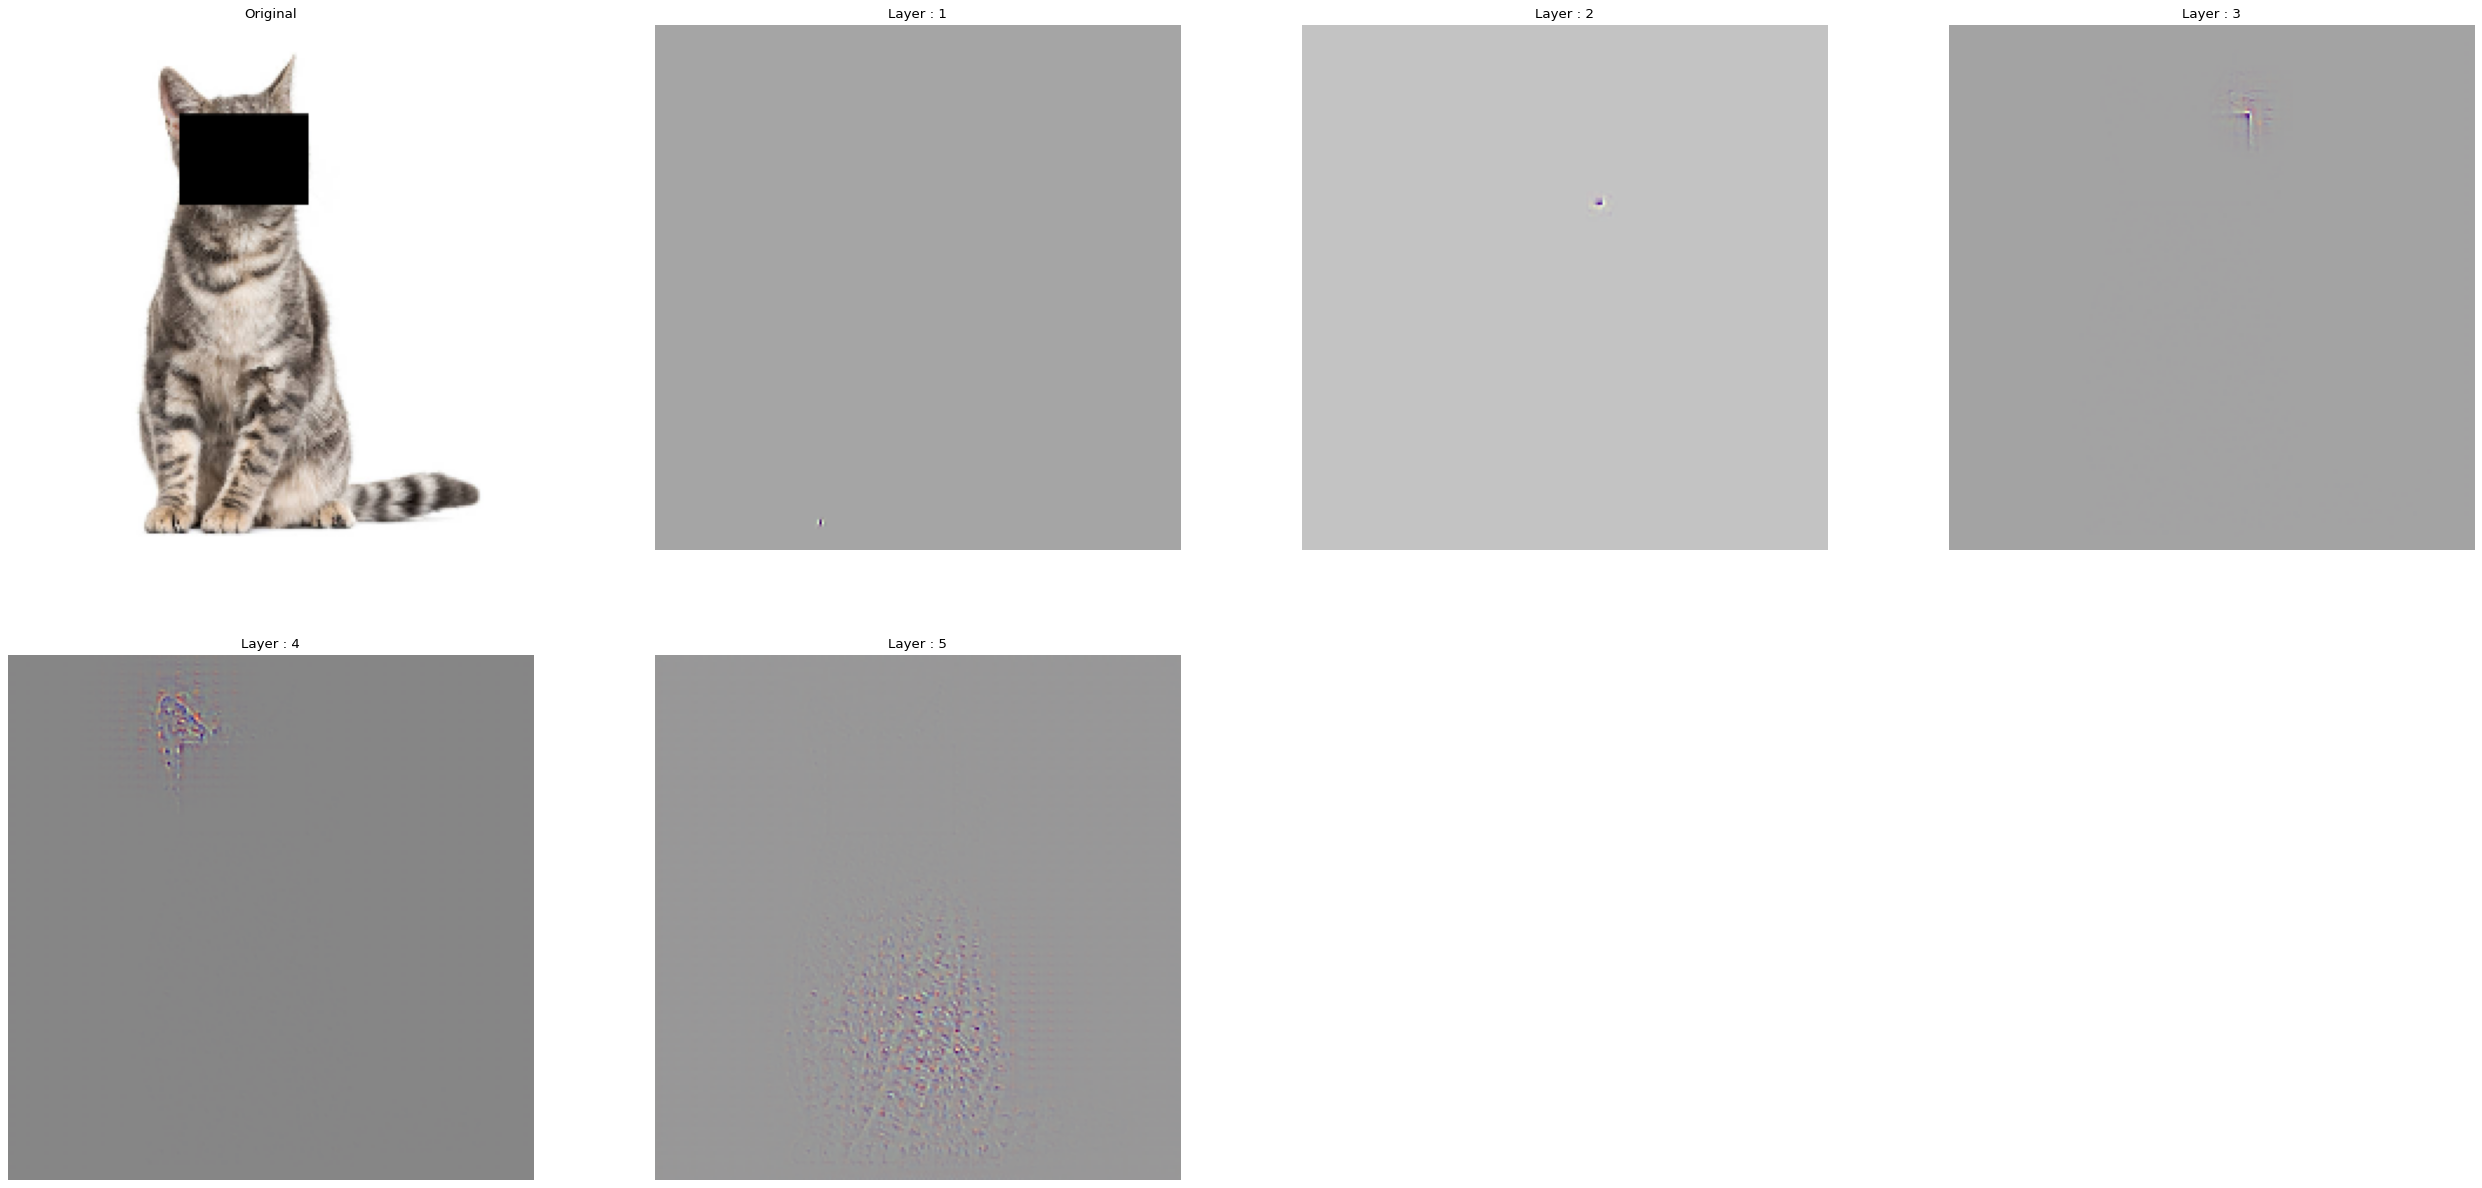

In [75]:
img_orig = cv2.imread('imgs/cat.jpg')
img_orig[100:200,200:350,:] = 0
visualise_for_image(img_orig, True, 281)

The score for the ground truth class zebra after occluding is = 18.46


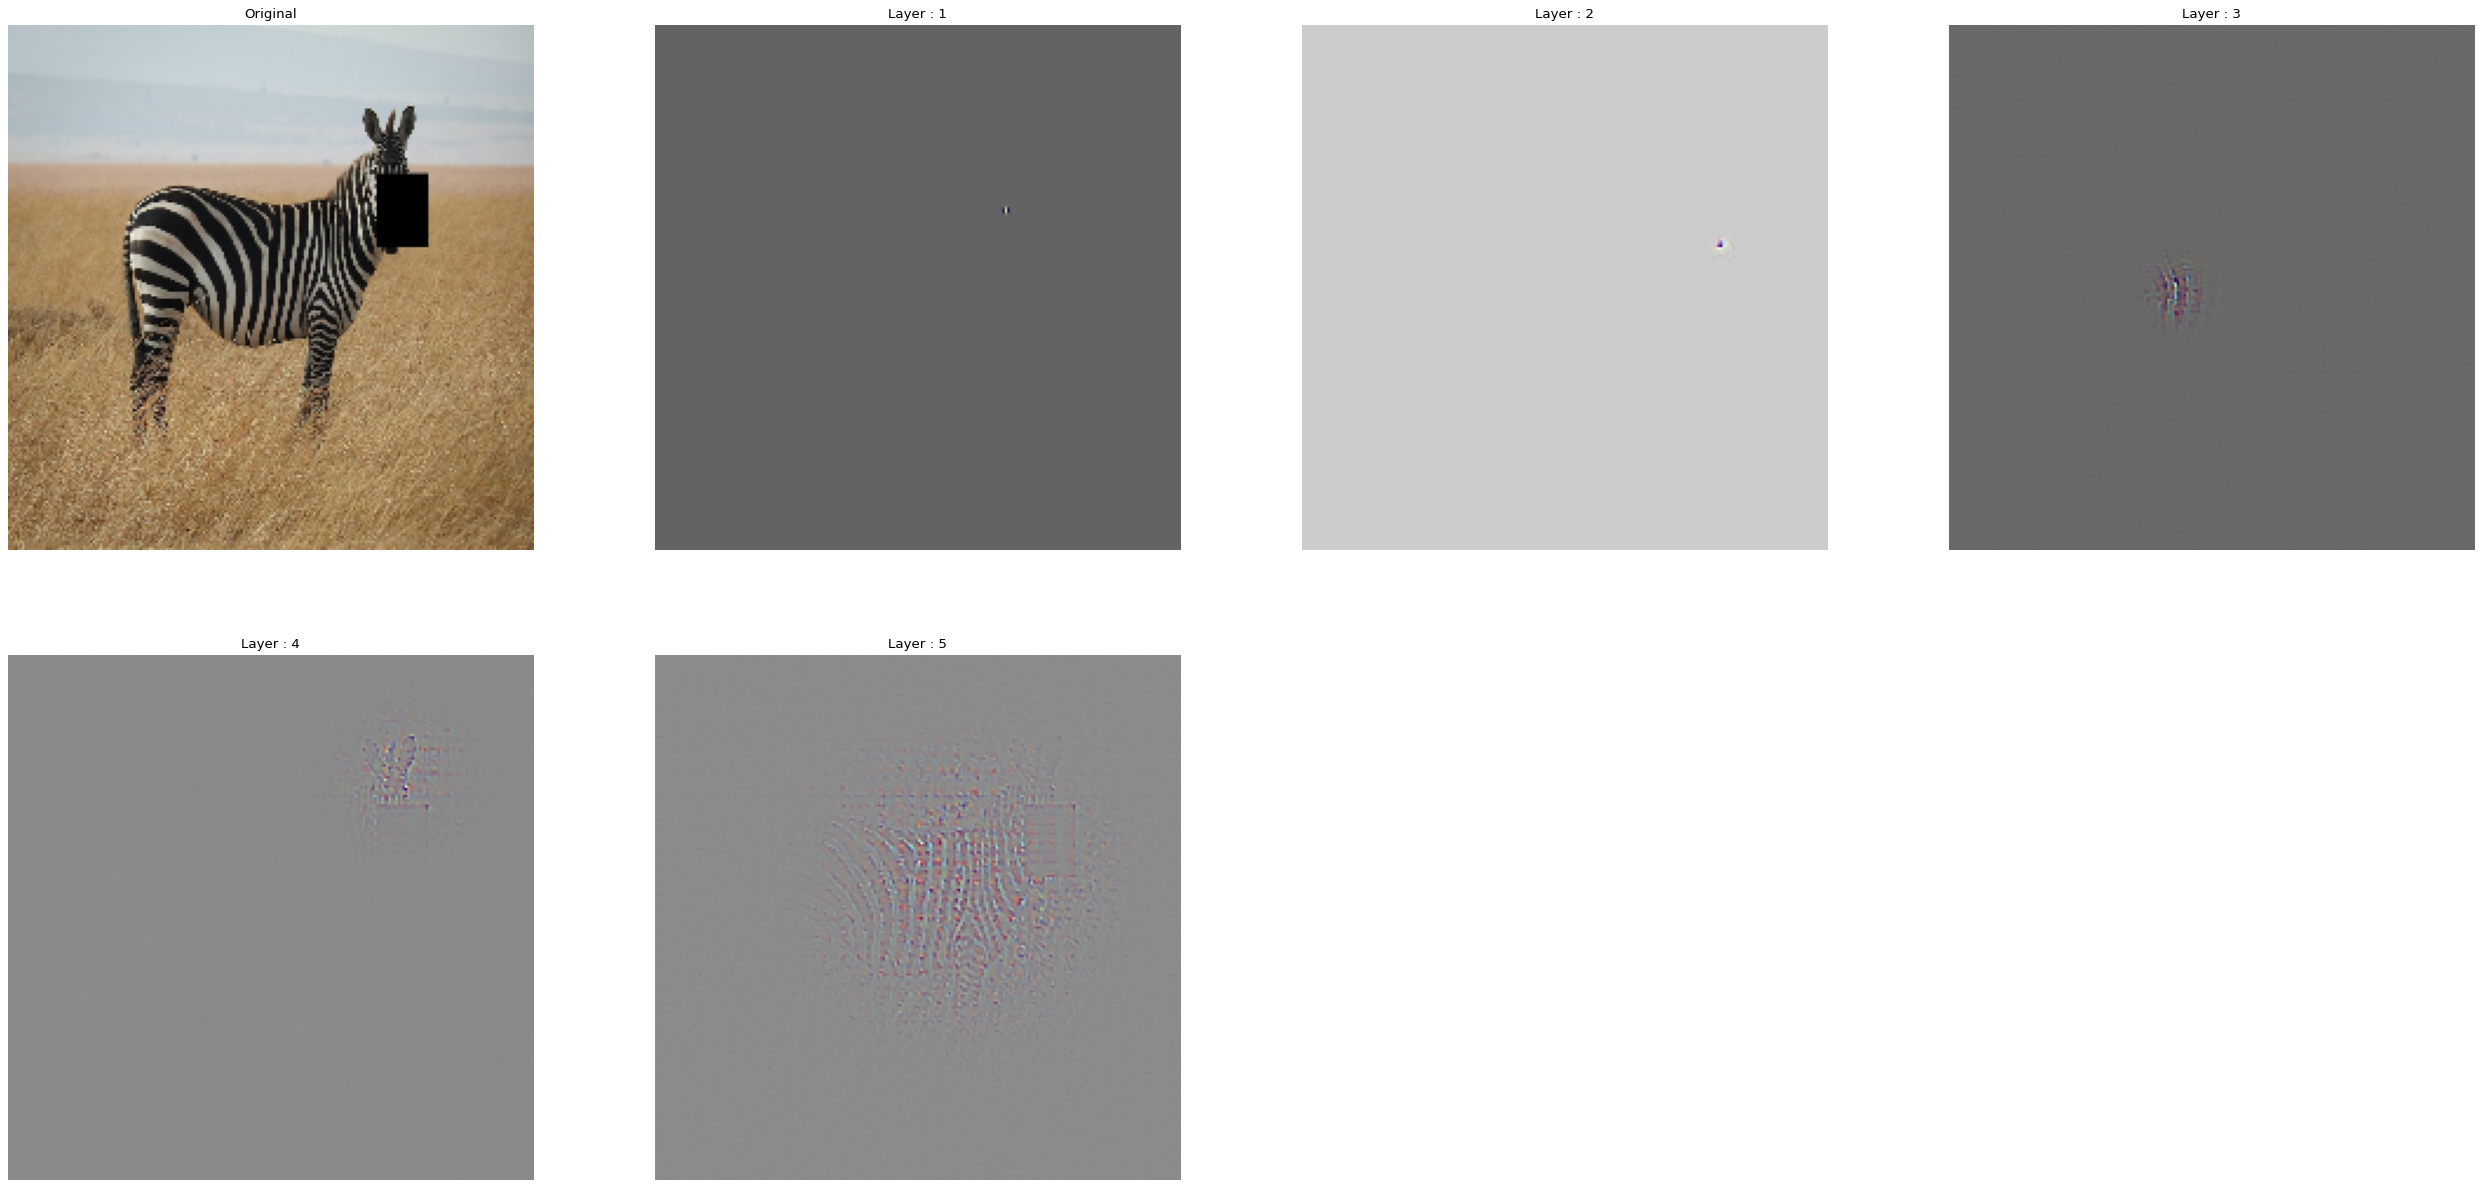

In [57]:
img_orig = cv2.imread('imgs/zebra.jpeg')
img_orig[200:300,700:800,:] = 0
visualise_for_image(img_orig, True, 340)

The score for the ground truth class hummingbird after occluding is = 7.34


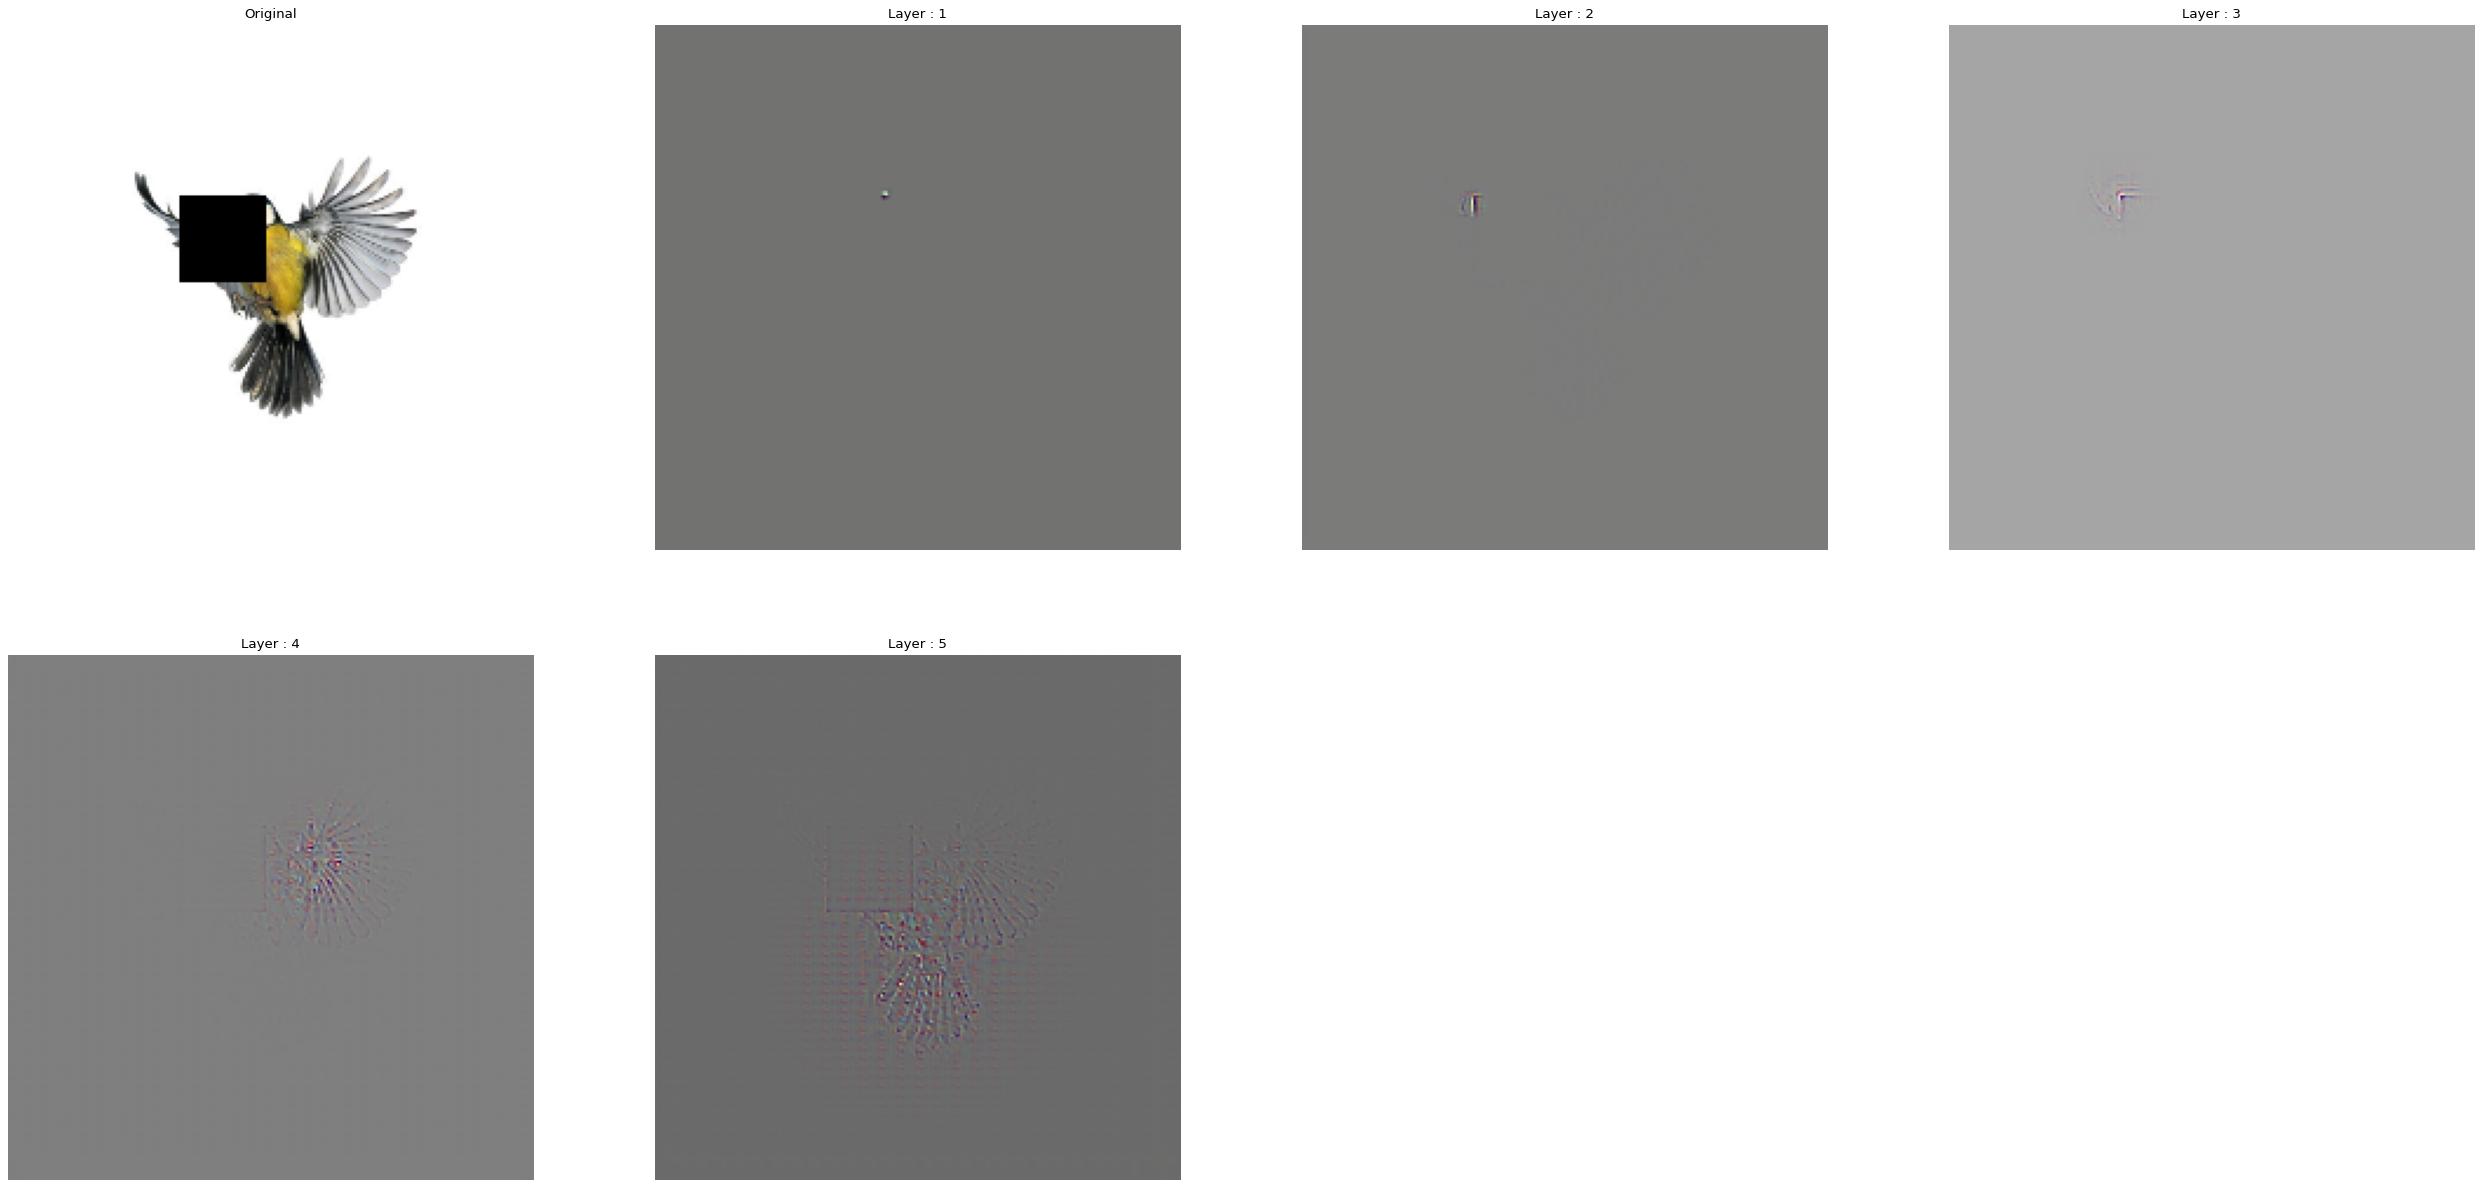

In [64]:
img_orig = cv2.imread('imgs/bird.jpg')
img_orig[200:300,200:300,:] = 0
visualise_for_image(img_orig, True, 94)

The score for the ground truth class kuvasz after occluding is = 4.25


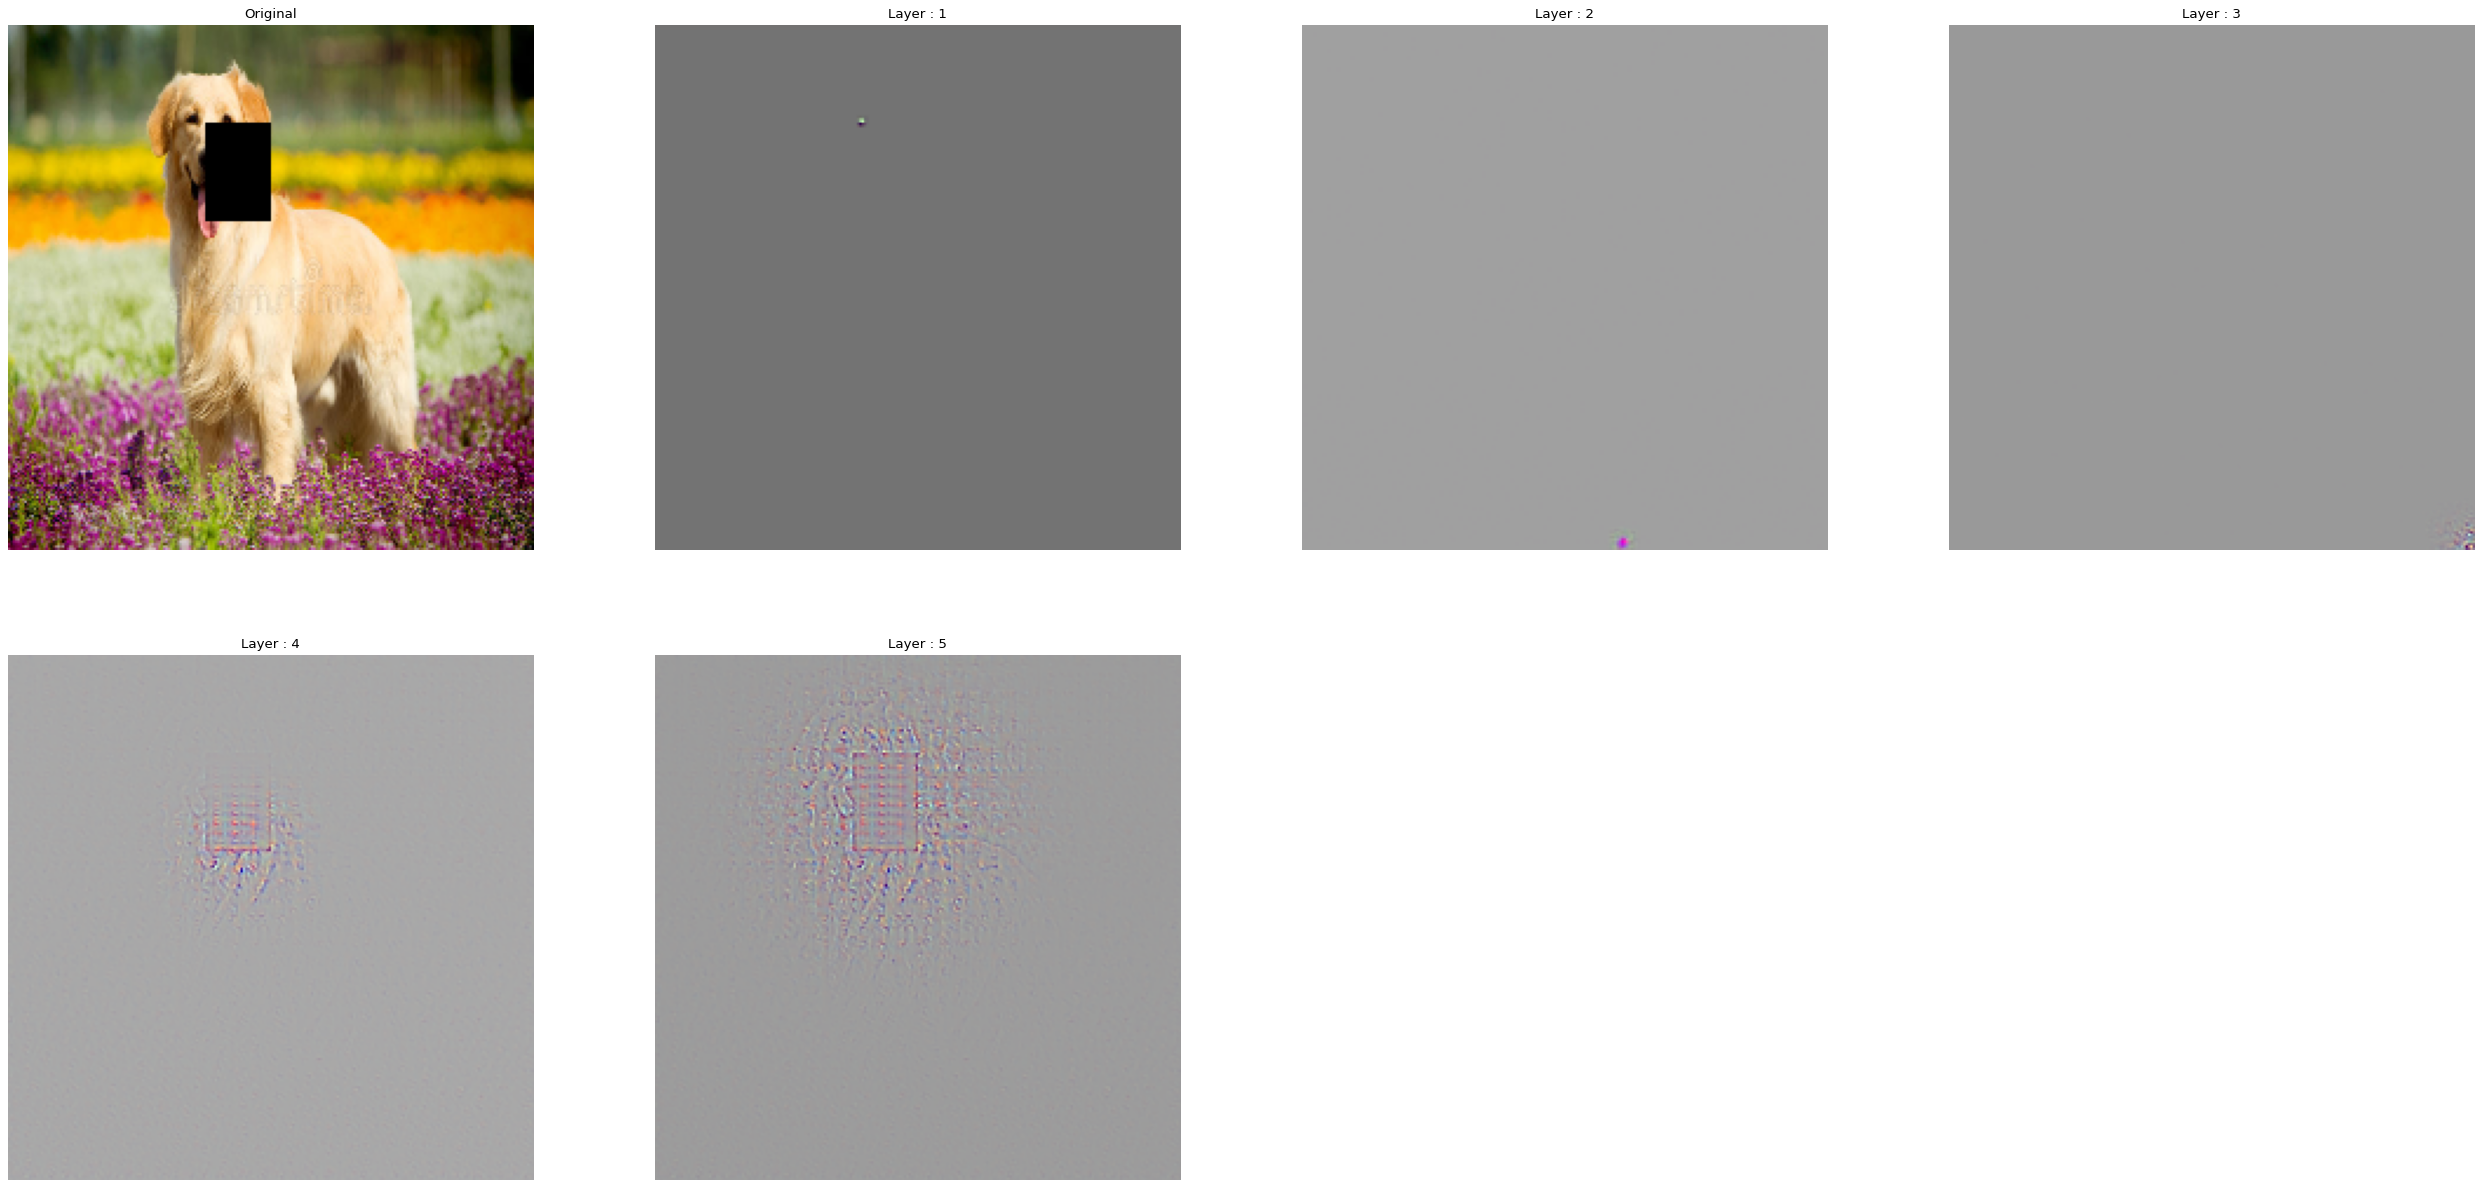

In [65]:
img_orig = cv2.imread('imgs/dog.jpg')
img_orig[100:200,300:400,:] = 0
visualise_for_image(img_orig, True, 222)

The score for the ground truth class daisy after occluding is = 11.46


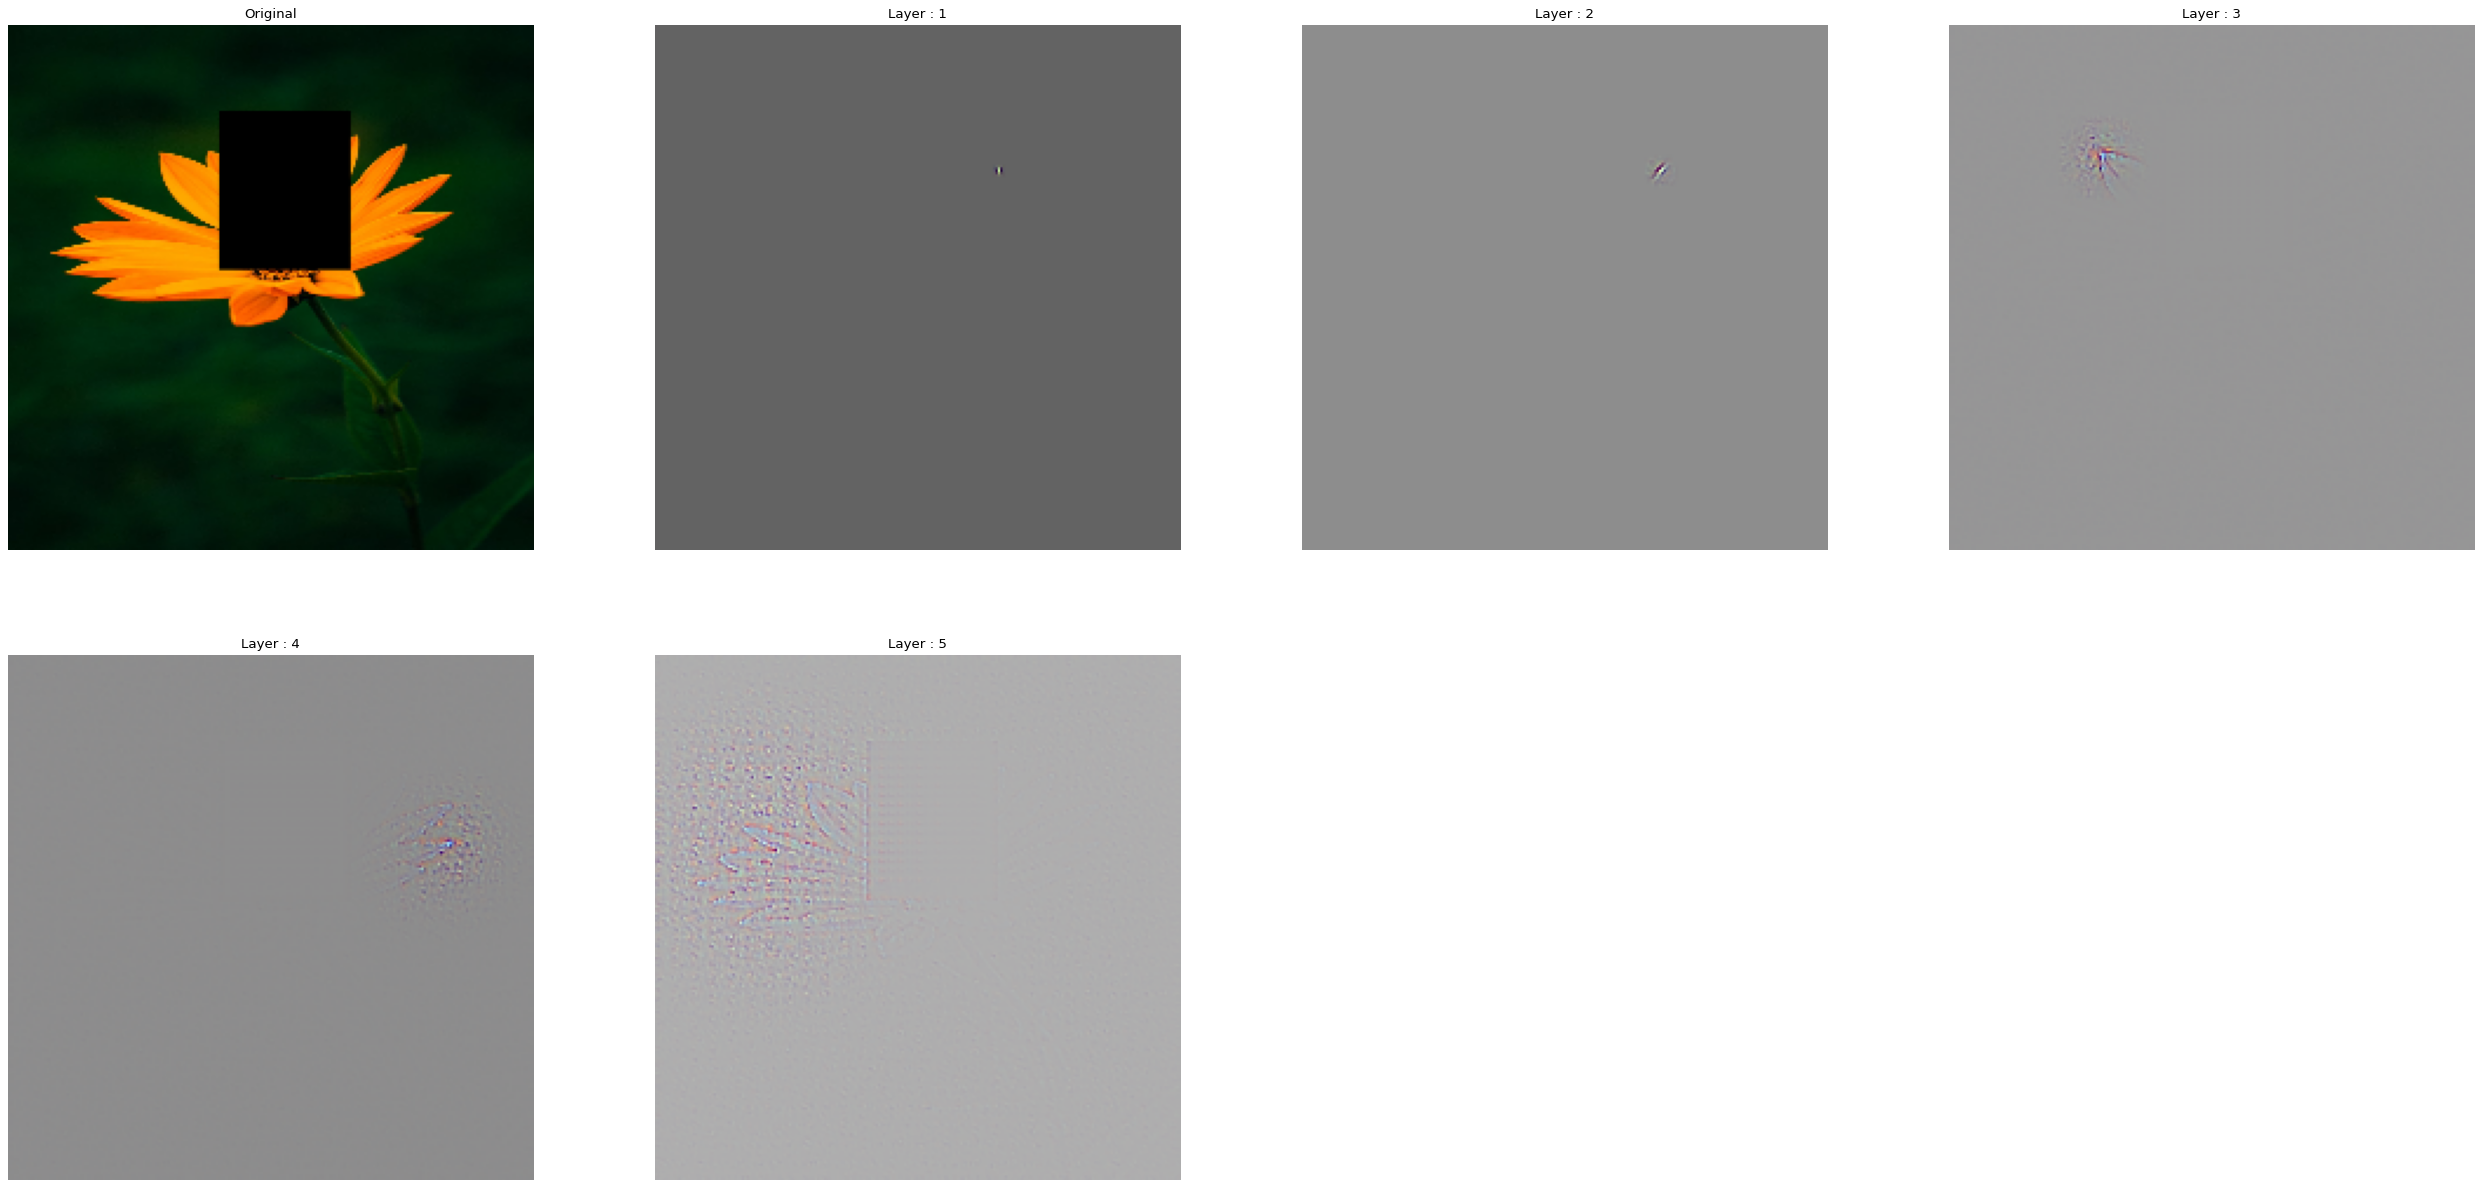

In [72]:
img_orig = cv2.imread('imgs/flower.jpeg')
img_orig[250:700,400:650,:] = 0
visualise_for_image(img_orig, True, 985)